# Phage biomass and AMG FVA

In this notebook, we use FVA to examine how optimizing for phage biomass instead of host biomass redistributes metabolic flux. 

We also examine how restricted AMG-hijacked reactions to specific target ranges redistributes flux globally, and compare it with the redistribution due to changing optimization criteria.

In [2]:
import cobra
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
import json
import numpy as np
from sklearn.decomposition import PCA

from amg_utils import amg_limits
from plotting_utils import plot_impact_graph

In [3]:
model = cobra.io.read_sbml_model("model_files/ProchlorococcusMED4+PHM2v1.xml")
amgs = json.loads(open("model_files/amg_reactions.json").read())
manual_relabels = json.loads(open("model_files/subsystem_alias.json").read())
amg_gene_names = json.loads(open("model_files/amg_gene_map.json").read())
amg_rxn_names = {k: f"{v}: {k}" for k, v in amg_gene_names.items()}

In [4]:
amg_rxn_names["FAKEOrthophosphateEX"] = "phoH: Phosphate Exchange"

## Basic FVA

Here, we run FVA--first with host biomass as the objective, then with phage biomass.

We plot highly-affected reaction flux ranges below.

In [5]:
with model as healthy:
    fva_healthy = cobra.flux_analysis.flux_variability_analysis(healthy)
with model as phm2:
    phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
    fva_phm2_no_amg = cobra.flux_analysis.flux_variability_analysis(phm2)
print(fva_healthy[fva_healthy.index == "BIOMASS"])
print(fva_healthy[fva_healthy.index == "PHM2_prodrxn_VN"])
print("-" * 80)
print(fva_phm2_no_amg[fva_phm2_no_amg.index == "BIOMASS"])
print(fva_phm2_no_amg[fva_phm2_no_amg.index == "PHM2_prodrxn_VN"])

          minimum   maximum
BIOMASS  0.098462  0.098462
                 minimum       maximum
PHM2_prodrxn_VN      0.0 -7.338573e-13
--------------------------------------------------------------------------------
         minimum       maximum
BIOMASS      0.0  9.387124e-14
                  minimum   maximum
PHM2_prodrxn_VN  0.150551  0.150551


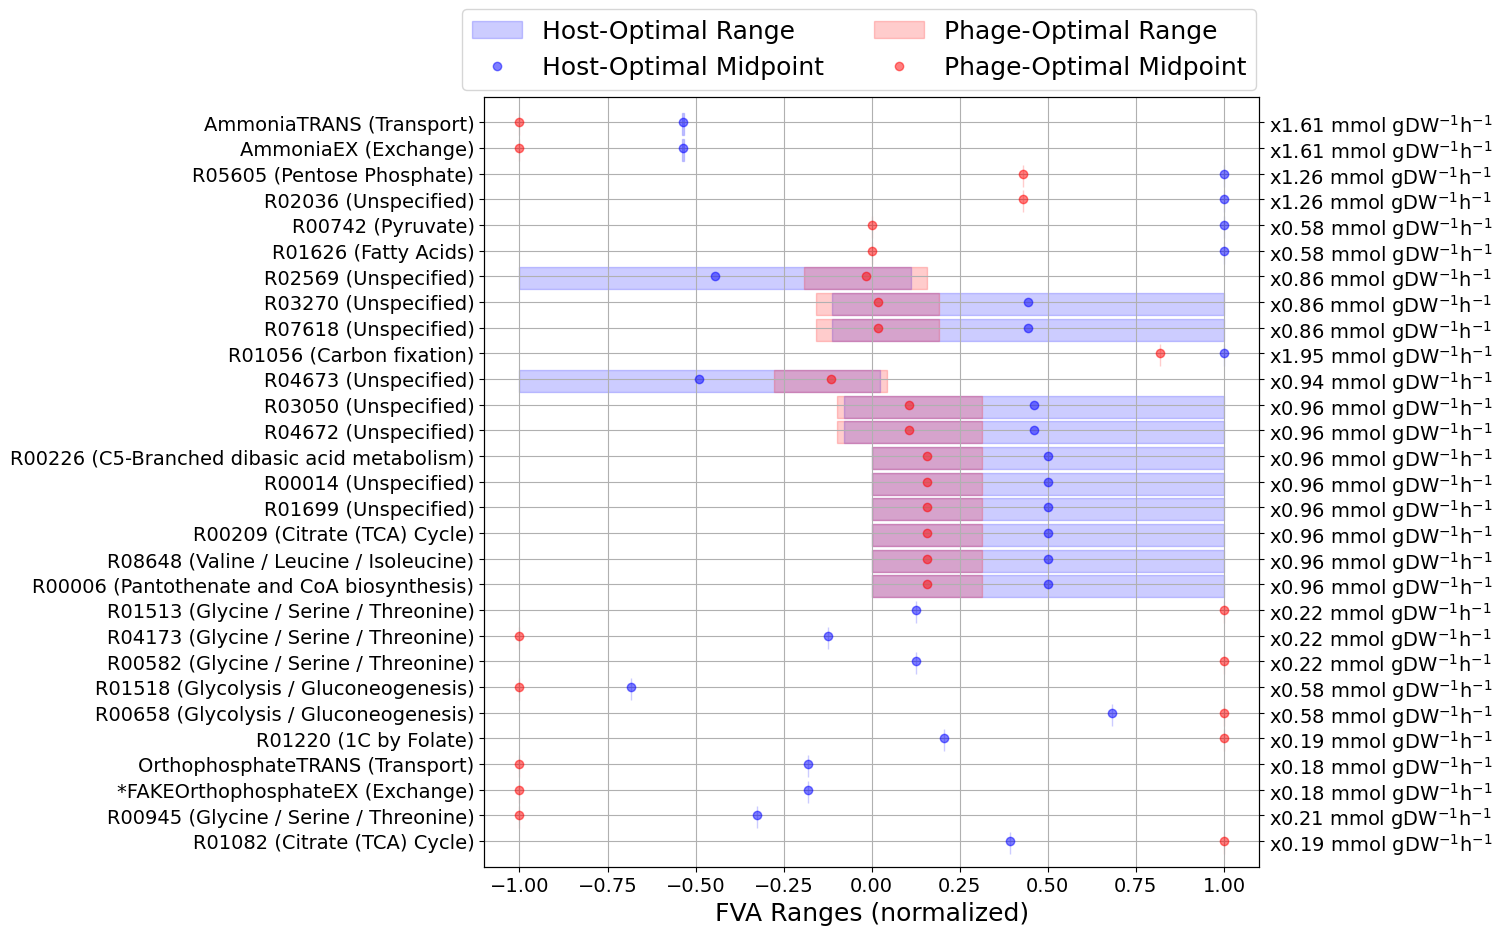

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_impact_graph(
    ax, model, fva_healthy, fva_phm2_no_amg, amgs, manual_relabels, cut=0.16
)
ax.tick_params(labelsize=14)
ax.xaxis.label.set_size(18)
fig.axes[1].tick_params(labelsize=14)
fig.legend(
    [
        "Host-Optimal Range",
        "Host-Optimal Midpoint",
        "Phage-Optimal Range",
        "Phage-Optimal Midpoint",
    ],
    ncols=2,
    loc="upper center",
    fontsize=18,
    bbox_to_anchor=(0.5, 0.98),
)
plt.show()

## "Lax" FVA for only AMG-hijacked reaction

We redo the FVA storing only the FVA ranges for AMG-hijacked reactions, and allowing for a wider tolerance in biomass production (75%).

In [7]:
# For some ridiculous reason, this is both faster and more numerically
# consistent that using the built-in reaction list feature...
h1 = {}
h2 = {}
i1 = {}
i2 = {}
for amg in amgs:
    with model as healthy:
        res = cobra.flux_analysis.flux_variability_analysis(
            healthy,
            [amg],
            fraction_of_optimum=0.25,
        )

    h1[amg] = res["minimum"][amg]
    h2[amg] = res["maximum"][amg]

    with model as phm2:
        phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
        res = cobra.flux_analysis.flux_variability_analysis(
            phm2,
            [amg],
            fraction_of_optimum=0.25,
        )
    i1[amg] = res["minimum"][amg]
    i2[amg] = res["maximum"][amg]

h1 = {k: v for k, v in sorted(h1.items(), key=lambda x: amg_rxn_names[x[0]])}
h2 = {k: v for k, v in sorted(h2.items(), key=lambda x: amg_rxn_names[x[0]])}
i1 = {k: v for k, v in sorted(i1.items(), key=lambda x: amg_rxn_names[x[0]])}
i2 = {k: v for k, v in sorted(i2.items(), key=lambda x: amg_rxn_names[x[0]])}

fva_healthy_amg2 = pd.DataFrame({"minimum": h1, "maximum": h2})
fva_phm2_amg2 = pd.DataFrame({"minimum": i1, "maximum": i2})

## Compute and plot AMG target ranges

Using the literature-curated reaction hijacking directions (stored in the `amgs` dictionary and `model_files/amg_reactions.json`), we determine a target range for each AMG by taking 10% of the phage-optimal range (with 50% tolerance). We then plot the resulting ranges.

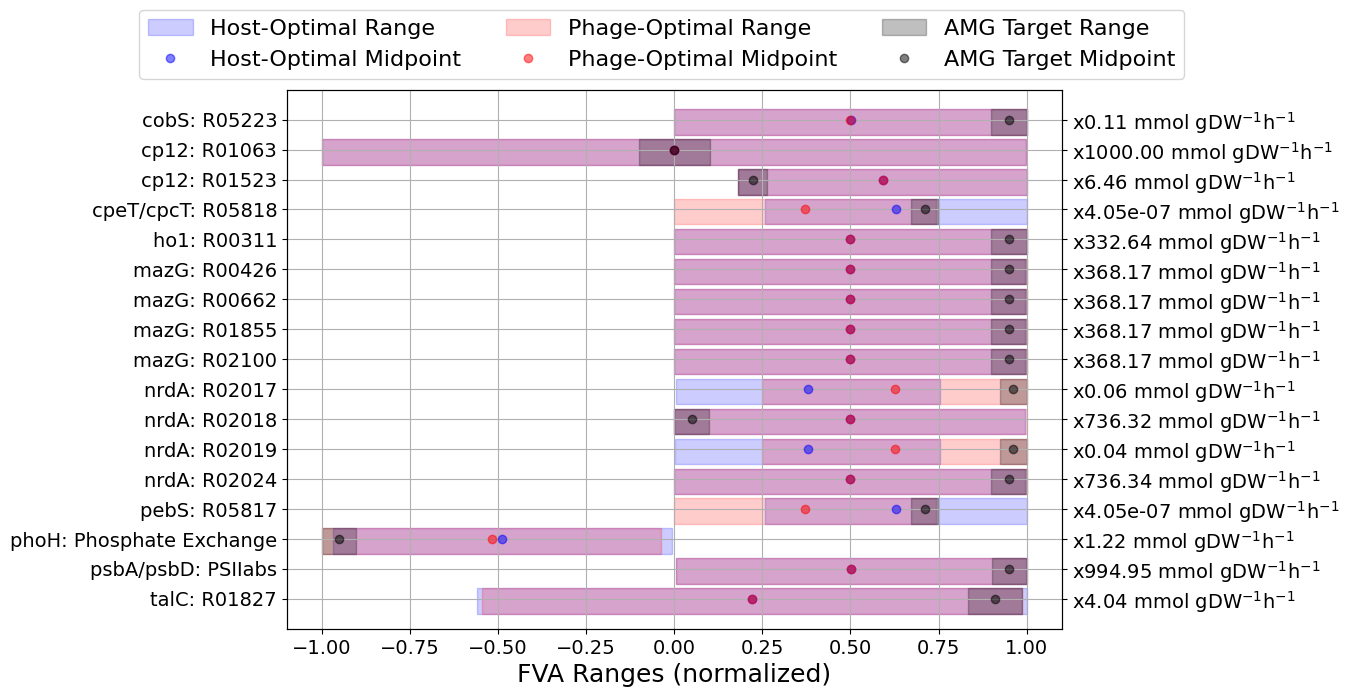

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
highlights = {}
for i, (amg, direction) in enumerate(amgs.items()):
    with model as phm2:
        phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
        lb, ub = amg_limits(phm2, amg, direction, optimum_fraction=0.25, tol=0.1)
    highlights[amg] = (lb, ub)
plot_impact_graph(
    ax,
    model,
    fva_healthy_amg2,
    fva_phm2_amg2,
    [],
    manual_relabels,
    cut=0,
    sort=False,
    highlights=highlights,
)
# ax.set_ylim(-11, 1.3)

ax.set_yticklabels(sorted(amg_rxn_names.values()))

ax.tick_params(labelsize=14)
ax.xaxis.label.set_size(18)
fig.axes[1].tick_params(labelsize=14)
# ax.set_title("Biomass Lax Optimization Impact on AMG-Hijacked Reactions", fontsize=22)
fig.legend(
    [
        "Host-Optimal Range",
        "Host-Optimal Midpoint",
        "Phage-Optimal Range",
        "Phage-Optimal Midpoint",
        "AMG Target Range",
        "AMG Target Midpoint",
    ],
    ncols=3,
    loc="upper center",
    fontsize=16,
    bbox_to_anchor=(0.5, 1.01),
)
plt.show()

## Global response to fixing AMG values

We measure the global response in FVA midpoints when setting each AMG-hijacked reaction to the midpoint of its target range. We store the change in FVA midpoint value for each reaction in the `mdf` dataframe.

In [9]:
amg_new_vals = {}
for amg, direction in amgs.items():
    with model as phm2:
        phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
        lb, ub = amg_limits(phm2, amg, direction, optimum_fraction=0.25, tol=0.1)
    amg_new_vals[amg] = (lb + ub) / 2
amg_new_vals

{'FAKEOrthophosphateEX': np.float64(-1.1622446156413173),
 'PSIIabs': np.float64(945.4538223488594),
 'R00311': np.float64(316.01089999376654),
 'R00426': np.float64(349.75913738986856),
 'R00662': np.float64(349.7591373898682),
 'R01063': np.float64(0.0),
 'R01523': np.float64(1.4393750000000125),
 'R01827': np.float64(3.678738491501404),
 'R01855': np.float64(349.7591373898593),
 'R02017': np.float64(0.05479197460924864),
 'R02018': np.float64(36.45001962247987),
 'R02019': np.float64(0.03374666945506511),
 'R02024': np.float64(699.5270401484256),
 'R02100': np.float64(349.75913738986094),
 'R05223': np.float64(0.10630952380951987),
 'R05817': np.float64(2.878024686102078e-07),
 'R05818': np.float64(2.878024686102078e-07)}

In [10]:
amg_fvas = {}
for amg, new_val in amg_new_vals.items():
    with model as phm2:
        phm2.reactions.get_by_id(amg).bounds = new_val, new_val
        fva_phm2 = cobra.flux_analysis.flux_variability_analysis(phm2)
    amg_fvas[amg] = fva_phm2.copy()


In [11]:
hmid = (fva_healthy["maximum"] + fva_healthy["minimum"]) / 2
mdiffs = {}
for amg, fva in sorted(amg_fvas.items()):
    mids = (fva["maximum"] + fva["minimum"]) / 2
    mid_diff = mids - hmid
    mdiffs[amg] = mid_diff
mdf = pd.DataFrame(mdiffs)

In [12]:
mdf = mdf.reindex(sorted(mdf.columns, key=lambda x: amg_rxn_names[x]), axis=1)
mdf

,R05223,R01063,R01523,R05818,R00311,R00426,R00662,R01855,R02100,R02017,R02018,R02019,R02024,R05817,FAKEOrthophosphateEX,PSIIabs,R01827
R01055,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
R00546,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
R05605,-8.976306e-01,-5.528911e-14,-8.743602e-01,-0.459695,1.338318e-10,-9.785330e-02,-9.785330e-02,-9.785330e-02,-9.785330e-02,-0.692409,1.976197e-14,-0.692523,-9.806288e-02,-0.459695,-9.279709e-01,-7.669421e-13,-7.711004e-01
R00346,3.627094e+00,-1.051603e-11,1.731309e+01,7.808528,-1.267625e+02,-1.729420e+02,-1.729420e+02,-1.729420e+02,-1.729420e+02,5.923112,-1.822550e+01,5.924084,-3.478216e+02,7.808528,6.551087e+00,-2.863689e+02,1.095512e+01
R00355,8.440255e-01,2.273737e-13,3.849868e+00,1.715788,-2.652598e-10,-1.192064e+02,-1.192064e+02,-1.192064e+02,-1.192064e+02,1.046313,2.359002e-12,1.046485,-1.192064e+02,1.715788,4.861403e-02,-1.113657e+02,3.395208e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R01078,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.358121e-13,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
Trans_H2O2,-7.801768e-03,3.237233e-11,-7.599513e-03,-0.003428,9.859306e+01,-8.504933e-04,-8.504932e-04,-8.504932e-04,-8.504932e-04,-0.010537,4.348522e-11,-0.010538,-8.523148e-04,-0.003428,-8.065471e-03,8.191670e-12,-6.702029e-03
H2O2EX,-7.801768e-03,3.832668e-11,-7.599513e-03,-0.003428,9.859306e+01,-8.504933e-04,-8.504932e-04,-8.504932e-04,-8.504932e-04,-0.010537,5.147172e-11,-0.010538,-8.523148e-04,-0.003428,-8.065471e-03,1.442313e-11,-6.702029e-03
R02036,-8.976306e-01,2.568701e-11,-8.743602e-01,-0.459695,1.497495e-10,-9.785330e-02,-9.785330e-02,-9.785330e-02,-9.785330e-02,-0.692409,2.754508e-11,-0.692523,-9.806288e-02,-0.459695,-9.279709e-01,1.266764e-11,-7.711004e-01


## Visualize impact

For visualization, we filter out reactions that are not substantially impacted, then plot a heatmap of affected reactions, organized by subsystem.

In [13]:
mdf_filtered = mdf[mdf.abs().max(axis=1) >= 0.25].apply(lambda x: x)
mdf_filtered["Phage Biomass"] = (
    fva_phm2_no_amg["maximum"] + fva_phm2_no_amg["minimum"]
) / 2 - hmid

mdf_filtered = mdf_filtered.sort_index(
    axis=0,
    key=lambda x: [model.reactions.get_by_id(y).subsystem for y in x],
)
last = ""
switch_inds = [(0, "Unspecified")]
for i, (rxn, row) in enumerate(mdf_filtered.iterrows()):
    ss = model.reactions.get_by_id(rxn).subsystem
    if last != ss:
        last = ss
        if ss in manual_relabels:
            ss = manual_relabels[ss]
        switch_inds.append((i, ss))

In [14]:
mdf_filtered

,R05223,R01063,R01523,R05818,R00311,R00426,R00662,R01855,R02100,R02017,R02018,R02019,R02024,R05817,FAKEOrthophosphateEX,PSIIabs,R01827,Phage Biomass
R02036,-8.976306e-01,2.568701e-11,-0.874360,-0.459695,1.497495e-10,-0.097853,-0.097853,-0.097853,-0.097853,-6.924093e-01,2.754508e-11,-6.925230e-01,-0.098063,-0.459695,-9.279709e-01,1.266764e-11,-7.711004e-01,-7.198615e-01
R00517,3.246854e+00,-8.617462e-11,17.408507,7.851564,-1.267625e+02,-347.810879,-172.931310,-172.931310,-172.931310,5.918796e+00,-1.496687e-10,5.919768e+00,1.952431,7.851564,6.652358e+00,-2.863689e+02,1.103927e+01,6.153460e+00
R00137,-1.633379e+00,-6.687628e-11,-8.713948,-3.930154,6.338125e+01,173.904354,173.904354,173.904354,173.904354,-2.919905e+00,9.112750e+00,-2.920385e+00,173.904354,-3.930154,-3.336468e+00,1.431845e+02,-5.528187e+00,-3.035672e+00
R07618,-2.729153e-01,-5.829004e-12,-0.265840,0.063926,-1.610806e-11,-0.029751,-0.029751,-0.029751,-0.029751,-3.543638e-01,-7.663981e-12,-3.544219e-01,-0.029815,0.063926,-2.821399e-01,1.013500e-11,-2.344451e-01,-3.684133e-01
R10221,4.488153e-01,-7.389644e-13,0.437180,0.932478,-1.618901e-10,0.048927,0.048927,0.048927,0.048927,3.462047e-01,1.421085e-11,3.462615e-01,0.049031,0.932478,4.639855e-01,1.085709e-11,3.016484e+00,3.599307e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CO2TRANS,4.482149e-02,3.410605e-12,1.622216,0.363999,-1.037961e-10,0.181549,0.181549,0.181549,0.181549,-3.936670e-01,-1.136868e-13,-3.937316e-01,0.181938,0.363999,-8.592849e-03,3.126388e-12,2.868413e+00,-4.092748e-01
AmmoniaTRANS,-1.088026e+00,-1.306555e-11,0.596370,-0.548028,4.398260e-11,0.066742,0.066742,0.066742,0.066742,-7.197681e-01,-3.191003e-12,-7.198862e-01,0.066885,-0.548028,6.329363e-01,-4.403145e-13,5.259404e-01,-7.483049e-01
3_Phospho_D_glycerateTRANScar,-1.950440e-12,-2.122569e-11,-6.521250,-1.102952,1.798455e-10,-0.729820,-0.729820,-0.729820,-0.729820,-3.286260e-12,-1.705303e-13,7.744916e-13,-0.731383,-1.102952,-3.595346e-12,-6.785683e-13,-5.890399e-12,-7.915446e-12
HCO3TRANScyt,1.222655e-01,-2.273737e-13,1.852920,0.835702,-1.519993e-10,0.207368,0.207368,0.207368,0.207368,2.060573e-01,-2.273737e-13,2.060912e-01,0.207812,0.835702,2.362567e-01,6.821210e-13,1.963183e-01,2.142270e-01


In [15]:
len(set(mdf_filtered.index) - set(amgs))

240

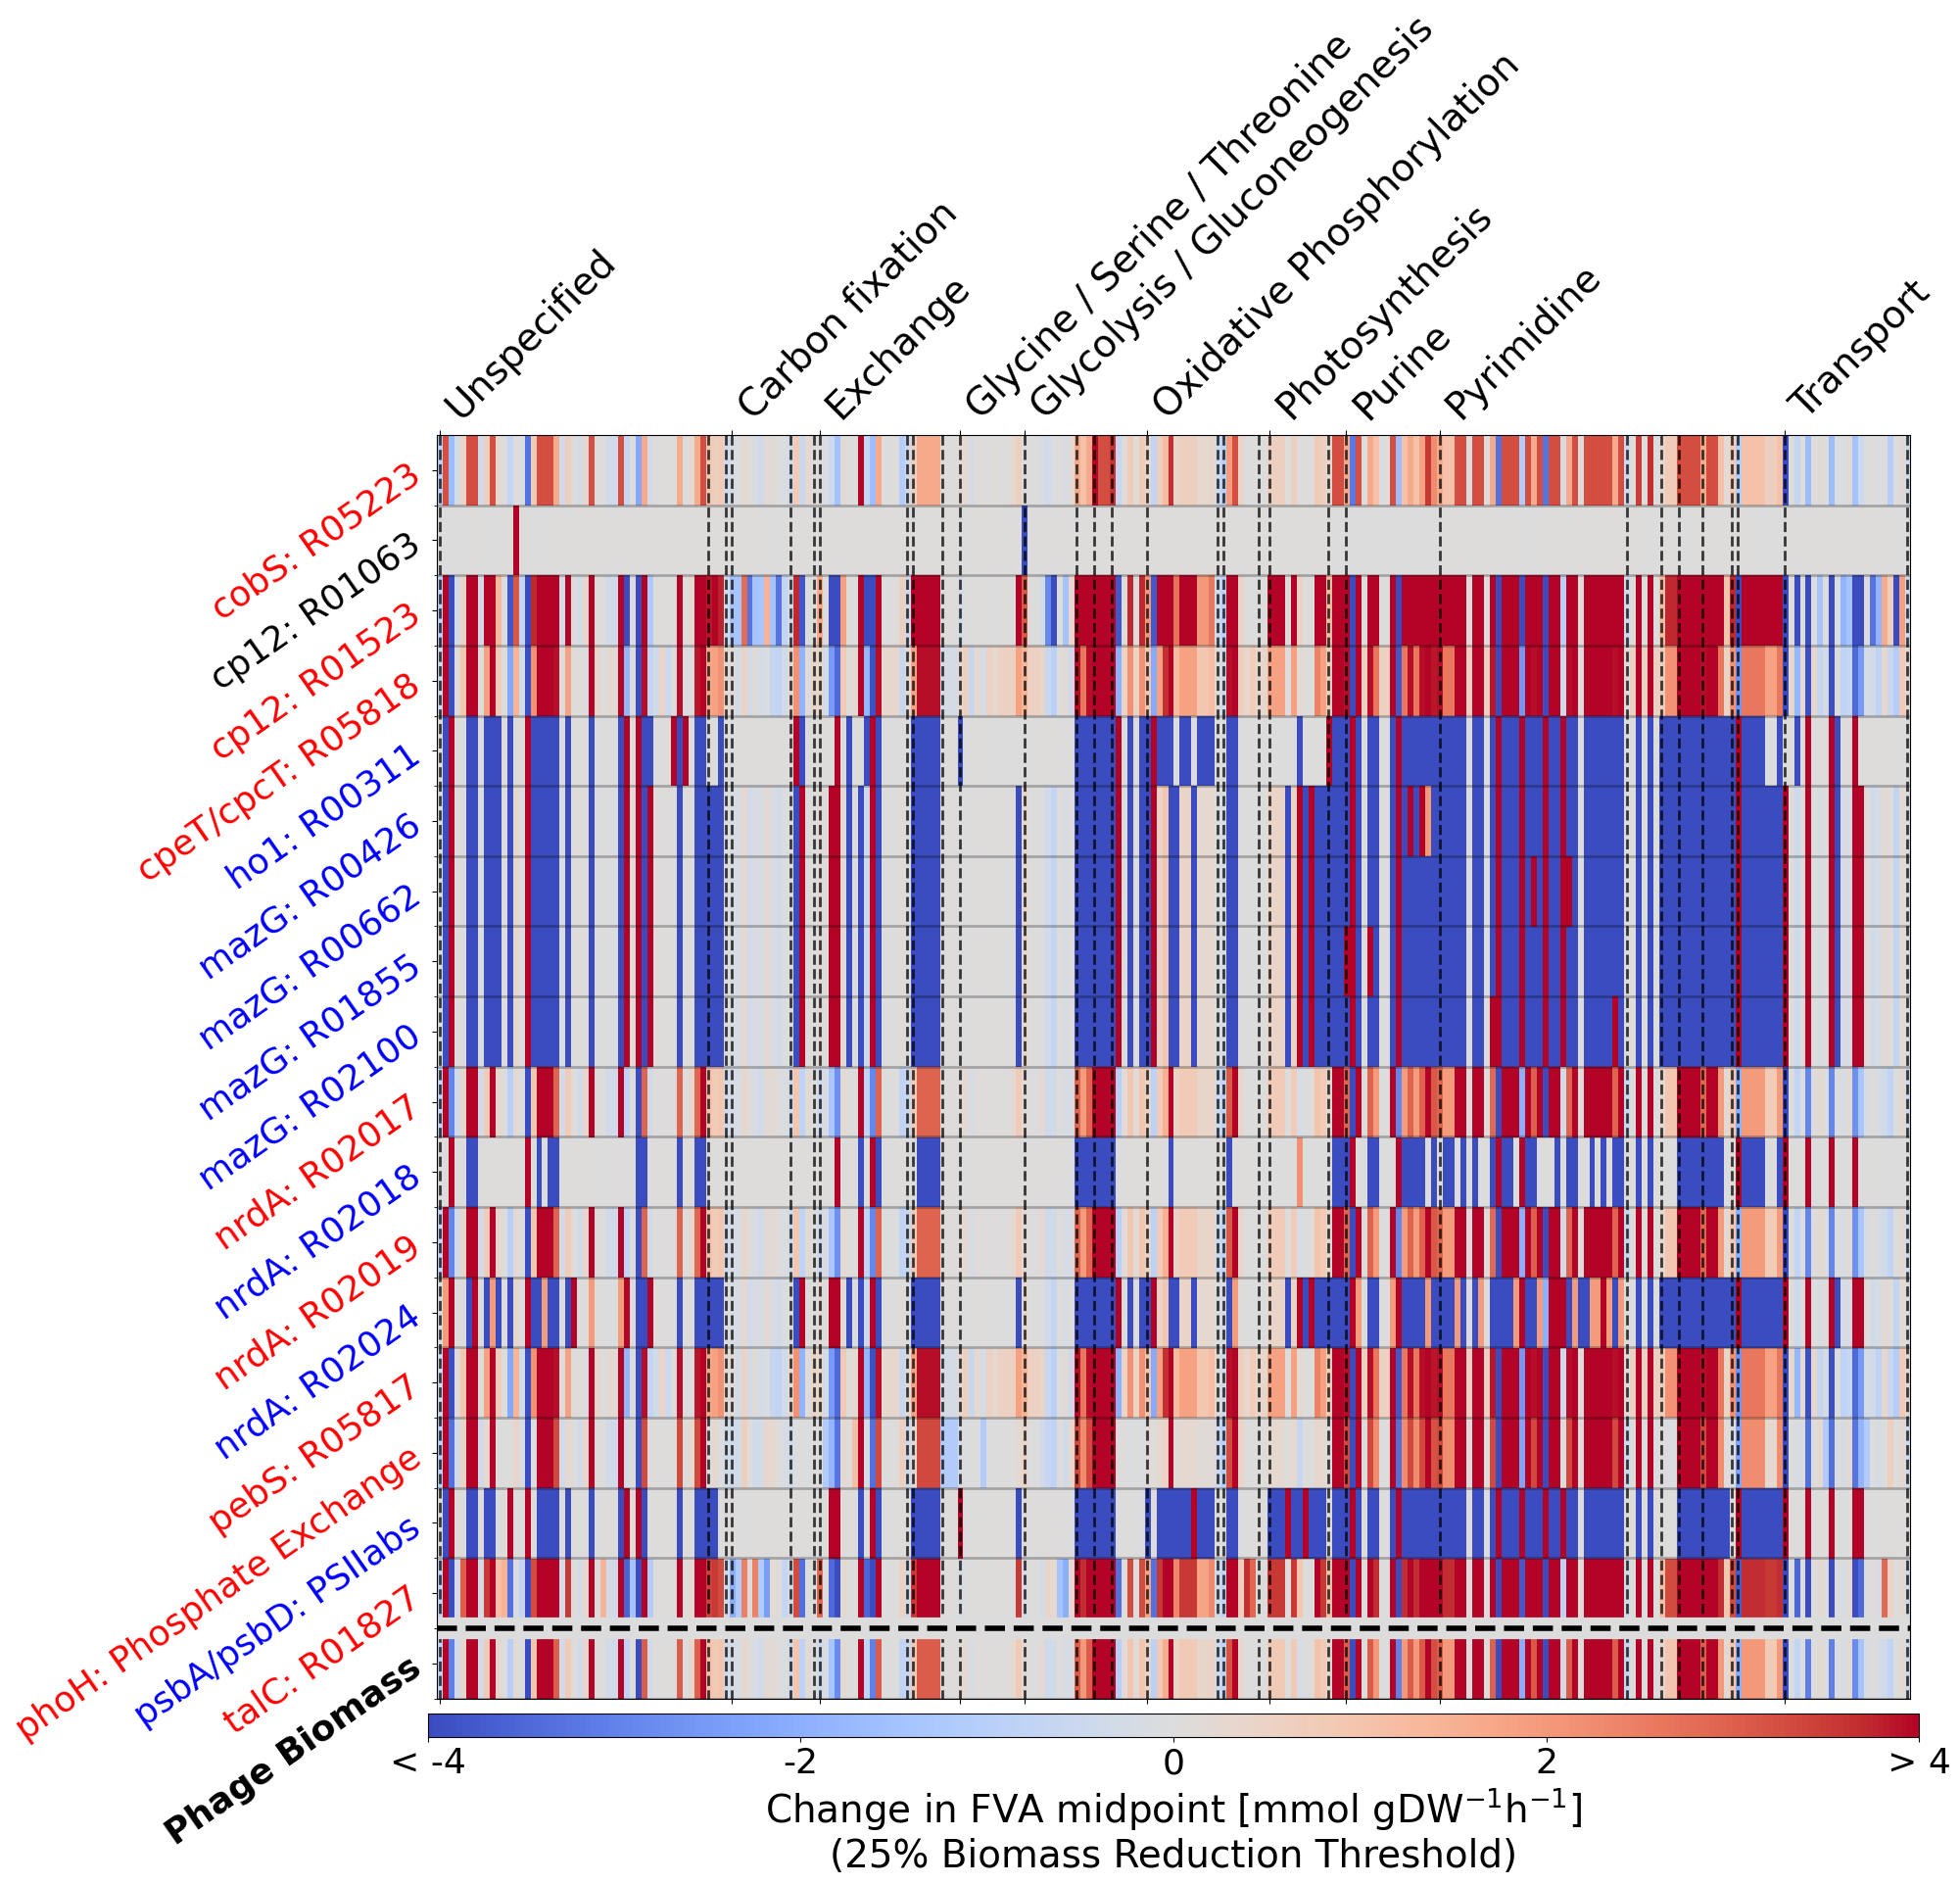

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
cmax = 4
im = ax.matshow(
    mdf_filtered.T,
    cmap="coolwarm",
    vmin=-cmax,
    vmax=cmax,
    aspect=12,
    interpolation="none",
)
ticks = range(1 + len(sorted(amgs.keys())))

ax.set_yticks(ticks, minor=False)
ax.set_yticks([0.5 + x for x in ticks], minor=True)
ax.set_yticklabels(
    sorted(amg_rxn_names.values()) + ["Phage Biomass"], fontsize=26, rotation=35
)


ax.set_xticks([])
ax.grid(True, which="minor", alpha=0.25, color="black", linewidth=2)
# ax.set_title(
#     "Impact on FVA reaction flux midpoints " + r"[mmol gDW$^{-1}$h$^{-1}$]", fontsize=32
# )
cbar = fig.colorbar(
    im,
    aspect=64,
    orientation="horizontal",
    pad=0.01,
)
cbar.set_ticks(
    ticks=[-cmax, -(cmax // 2), 0, cmax // 2, cmax],
    labels=[f"< -{cmax}", f"-{cmax//2}", "0", f"{cmax//2}", f"> {cmax}"],
    fontsize=26,
)
cbar.set_label(
    "Change in FVA midpoint [mmol gDW$^{-1}$h$^{-1}$]\n(25% Biomass Reduction Threshold)",
    fontsize=28,
)
offset = -3.5
tls = []
for line, (i, ss) in enumerate(switch_inds):
    if ss == "":
        ss = "Unspecified"
    ax.vlines(
        i,
        -0.5,
        len(amgs) + 0.5,
        linestyles="dashed",
        color="black",
        alpha=0.75,
        linewidth=2,
    )
    if (line < len(switch_inds) - 1) and switch_inds[line + 1][0] - i > 8:
        # ax.text(
        #     i + 1.5,
        #     len(amgs) - abs(offset) + offset,
        #     ss,
        #     horizontalalignment="left",
        #     verticalalignment="bottom",
        #     fontsize=24,
        #     fontweight="bold",
        #     rotation=90,
        #     color="black",
        #     alpha=0.8,
        #     # backgroundcolor="#c0c0c000",
        #     path_effects=[pe.withStroke(linewidth=6, foreground="#ffffff", alpha=0.9)],
        # )
        tls.append((i, ss))
        offset *= -1
ax.set_xticks([i for i, _ in tls])
ax.set_xticklabels([ss for _, ss in tls], fontsize=28, rotation=45, ha="left")
ax.axhline(len(amgs) - 0.5, color=plt.get_cmap("coolwarm")(0.5), linewidth=16)
ax.axhline(len(amgs) - 0.5, linestyle="dashed", color="black", linewidth=4)
for i, tlab in enumerate(ax.axes.yaxis.get_ticklabels()):
    if tlab.get_text() == "Phage Biomass":
        tlab.set_fontweight("bold")
    elif mdf_filtered.T.iloc[i].sum() > 10:
        tlab.set_color("#ff0000")
    elif mdf_filtered.T.iloc[i].sum() < -10:
        tlab.set_color("#0000ff")
fig.tight_layout()
# fig.savefig("phage_barcode.png")
plt.show()

## PCA

We conduct PCA on the full FVA midpoint response matrix, and plot the loadings.

In [17]:
from sklearn.preprocessing import StandardScaler

pcadf = pd.concat([mdf.iloc[:, 0] * 0, mdf], axis=1)
pcadf.columns = ["No AMG"] + list(mdf.columns)
pcadf.drop("No AMG", axis=1, inplace=True)
pcadf["Phage Biomass"] = (
    fva_phm2_no_amg["maximum"] + fva_phm2_no_amg["minimum"]
) / 2 - hmid
# df_normalized = ((pcadf - pcadf.mean()) / pcadf.std()).fillna(0)
scaler = StandardScaler()
scaler.fit(pcadf)
df_normalized = scaler.transform(pcadf)
pca = PCA()
pca.fit(df_normalized)
variances = pca.explained_variance_ratio_
v1 = variances[0]
v2 = variances[1]
# Reformat and view results
pc_proj = pd.DataFrame(
    pca.components_.T,
    columns=["PC%s" % _ for _ in range(df_normalized.shape[1])],
    index=pcadf.columns,
)

pc_proj = pc_proj.reindex(
    sorted(pc_proj.index, key=lambda x: amg_rxn_names[x] if x != "Phage Biomass" else x)
)
# pc_proj = pc_proj / (pc_proj.max() - pc_proj.min())

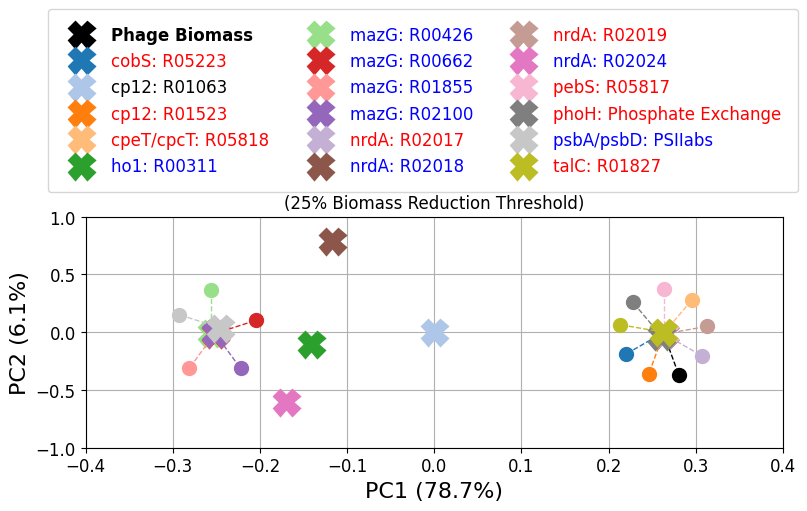

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
lab_colors = {}
for i, (amg, row) in enumerate(pc_proj.iterrows()):
    x = row["PC0"]
    y = row["PC1"]
    if amg == "No AMG":
        continue
    r, g, b, a = (
        plt.get_cmap("tab20")(i - 1) if amg != "Phage Biomass" else (0, 0, 0, 1)
    )
    lab = amg_rxn_names[amg] if amg != "Phage Biomass" else amg
    ax.plot(
        x,
        y,
        label=lab,
        marker="X",
        linestyle="None",
        markerfacecolor=(r, g, b, a),
        markeredgecolor=(r, g, b, a),
        markeredgewidth=2,
        ms=18,
    )
    if x > 0.1:
        lab_colors[lab] = "#ff0000"
    elif x < -0.1:
        lab_colors[lab] = "#0000ff"
    else:
        lab_colors[lab] = "#000000"
    if lab == "Phage Biomass":
        lab_colors[lab] = "#000000"
    # rng = np.random.RandomState(i * 42)
    # rn = rng.random() * np.pi * 2
    # rn = 0
    # for cval in sorted(pc_proj["PC0"]):
    #     if x < -0.2:
    #         rn += np.pi * 2 / (sum(pc_proj["PC0"] < -0.2))
    #     elif x > 0.2 and cval > 0.2:
    #         rn += np.pi * 2 / (sum(pc_proj["PC0"] > 0.2))
    #     if cval > x:
    #         break
    if x < -0.2:
        nth = sum(pc_proj["PC0"] < -0.2)
        xi = sum(pc_proj["PC0"] < x)
        rn = 2 * np.pi * xi / nth
        jx, jy = 0.05 * np.sin(rn), 0.75 / 2 * np.cos(rn)
    elif x > 0.2:
        nth = sum(pc_proj["PC0"] > 0.2)
        xi = sum(pc_proj["PC0"] > x)
        rn = 2 * np.pi * xi / nth
        jx, jy = 0.05 * np.sin(rn), 0.75 / 2 * np.cos(rn)
    else:
        jx, jy = 0, 0

    ax.plot(
        x + jx,
        y + jy,
        # label=amg_rxn_names[amg] if amg != "Phage Biomass" else amg,
        marker="o",
        linestyle="None",
        markerfacecolor=(r, g, b, 1),
        markeredgecolor=(r, g, b, a),
        markeredgewidth=2,
        ms=9,
    )
    ax.plot(
        x + jx,
        y + jy,
        # label=amg_rxn_names[amg] if amg != "Phage Biomass" else amg,
        marker="o" if amg != "Phage Biomass" else "x",
        linestyle="None",
        markerfacecolor=(r, g, b, a),
        markeredgecolor=(r, g, b, a),
        markeredgewidth=2,
        ms=1 if amg != "Phage Biomass" else 5,
    )
    ax.plot(
        [x, x + jx],
        [y, y + jy],
        color=(r, g, b, a),
        linewidth=1,
        linestyle="--",
    )
ax.grid(True)
ax.tick_params(axis="both", which="both", labelsize=12)
ax.set_xlabel(f"PC1 ({v1:.1%})", fontsize=16)
ax.set_ylabel(f"PC2 ({v2:.1%})", fontsize=16)
leg = fig.legend(
    ncols=3,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.6),
    fontsize=12,
    labelspacing=0.5,
    borderpad=1,
)

for tlab in leg.get_texts():
    tlab.set_color(lab_colors[tlab.get_text()])
    if tlab.get_text() == "Phage Biomass":
        tlab.set_fontweight("bold")
ax.set_xlim([-0.4, 0.4])
ax.set_ylim([-1, 1])
ax.set_title("(25% Biomass Reduction Threshold)")
plt.show()